References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

In [ ]:
pip install neuron

     |████████████████████████████████| 12.6 MB 25.1 MB/s 


## Move nvninmodl files to curr_dir (for ORN)


In [ ]:
# !nrnivmodl

**Stage 1:Importing required libraries**

In [ ]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()
size = 30

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

### **Stage 2:Making a Neuron with specific properties**

In [ ]:
# #This is the ORN class
# class ORN:
#     def __init__(self,gid,M):
#         self._gid = gid
#         self.M = M+1

#         # Set morphology
#         self.soma = h.Section(name='soma', cell=self)
#         self.axon = h.Section(name='axon', cell=self)
#         self.dendArr = [h.Section(name="dend%d" % i, cell=self) for i in range(1)]
#         self.dendriticknobArr = [h.Section(name="dendriticknob%d" % i, cell=self) for i in range(1)]
#         self.ciliumArr = [h.Section(name="cilium%d" % i, cell=self) for i in range(1)]

#         self.axon.connect(self.soma(0),0)
#         self.dendArr[0].connect(self.soma(1),0)
#         self.dendriticknobArr[0].connect(self.dendArr[0](0),1)
        
#         self.dendriticknobArr[0].nseg = 1
#         self.dendriticknobArr[0].diam = 2
#         self.dendriticknobArr[0].L = 2
#         self.dendriticknobArr[0].insert('ciliaProp')

#         for i in range(1):
#             self.ciliumArr[i].connect(self.dendriticknobArr[0](1),0)

# #         self._spike_detector = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
# #         self.spike_times = h.Vector()
# #         self._spike_detector.record(self.spike_times)
# #         self.axon_v = h.Vector().record(self.axon(0.5)._ref_v)
# #         self._ncs = [] 

#         # anatomical and biophysical properties
#         self.soma.nseg = 1 
#         self.soma.L = 9 # micrometer
#         self.soma.diam = 6
#         self.soma.insert('hh1')

#         self.axon.nseg = 1
#         self.axon.L = 100
#         self.axon.diam = 1
#         self.axon.insert('hh')
    
#         self.dendArr[0].nseg = 1
#         self.dendArr[0].L = 50
#         self.dendArr[0].diam = 1.5
#         self.dendArr[0].insert('dendProp')
#         # self.dendArr[0].e_pas = -65
#         # self.dendArr[0].g_pas = 0.001

#         for i in range(1):
#             self.ciliumArr[i].nseg = 1
#             self.ciliumArr[i].diam = 0.28
#             self.ciliumArr[i].L = 200
#             self.ciliumArr[i].insert("blr300%d" % i)

#         self.tstop = 6
        
#     def __repr__(self):
#         return 'Set [{}]_ORNcell [{}]'.format(self.M,self._gid)
#         #This shows how to represent each part when called upon

In [ ]:
#This class makes one cell neuron(soma,axon,dendrite)
class MCELL:
    def __init__(self, gid, M):
        self._gid = gid #Neuron no.
        self.M = M+1
        #Setting morphology
        #Creating soma,dend and axon
        self.soma=h.Section(name='soma',cell=self)
        self.dend=h.Section(name='dend',cell=self)
        self.axon=h.Section(name='axon',cell=self)
        
        self.all = [self.axon, self.soma, self.dend] 
        #list of all the sections in the cell.
        #We could explicitly specify the connection location  by self.dend.connect(self.soma(0.5))
        
        self.dend.connect(self.soma,1,0)
        self.axon.connect(self.soma,0,0)
        
        self._spike_detector = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        self.axon_v = h.Vector().record(self.axon(0.5)._ref_v)
        self._ncs = [] 
        
        #Defining geometry of soma
        self.soma.L = 18.8 
        self.soma.diam = 18.8 #in microns
        self.soma.nseg = 1                  #No. of segments
        
        #Defining geometry of dend
        self.dend.nseg = 1                  #No. of segments
        self.dend.L = 701.9                 #in microns
        self.dend.diam = 3.18                #in microns
        self.dendexcisyn = h.ExpSyn(self.dend(0.5))
        self.dendexcisyn.tau = 1 *ms   # tau is decay time constant
        self.dendexcisyn.e = 0    # reversal potential
        
        #Defining geometry for axon
        self.axon.nseg = 1
        self.axon.L = 152
        self.axon.diam = 3.18
        
        #Setting biophysics
        for sec in self.all:                                                  
            sec.Ra = 123    # Axial resistance in Ohm * cm                    
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        
        self.soma.insert('hh')            #Inserting HH neurons
        self.axon.insert('hh')
        self.dend.insert('pas')
        for seg in self.dend:                               
            seg.pas.g = 0.001  # Passive conductance in S/cm2 
            seg.pas.e = -78    # Leak reversal potential mV
        
    def __repr__(self):
        return 'Set [{}]_Mcell [{}]'.format(self.M,self._gid)
        #This shows how to represent each part when called upon

### **Uniform Distribution**

In [ ]:
# from scipy.stats import uniform
# label=['Pdf','Histogram']
low, high = 0.05, 0.09
uniform_distribution = np.random.uniform(low, high,2*size-1)
print(uniform_distribution)
# Create the bins and histogram
# count, bins, ignored = plt1.hist(uniform_distribution,10)
# #plt1.plot(bins, np.ones_like(bins), linewidth=2, color='r')
# plt1.plot(bins,uniform.pdf(bins))
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.grid()
# plt1.show()
# print(uniform_distribution)

[0.07437808 0.05732608 0.07470248 0.06985998 0.07793958 0.05705754
 0.07539535 0.05094433 0.08962507 0.08186752 0.05498963 0.05191554
 0.08809767 0.07835436 0.0772384  0.05157133 0.0547875  0.07841998
 0.08849542 0.06242735 0.08579937 0.06673105 0.08173731 0.07014171
 0.05995047 0.06545417 0.08599611 0.06648897 0.07587669 0.0695316
 0.07418294 0.06310871 0.06221377 0.05715843 0.06286097 0.07332565
 0.08703378 0.05584269 0.05880094 0.06678917 0.06436079 0.07202343
 0.06476338 0.08230886 0.06907183 0.07049337 0.05845226 0.0617481
 0.08928578 0.06232096 0.0704924  0.07215742 0.06331755 0.07033578
 0.05501721 0.08030346 0.08823118 0.06770006 0.06173683]


In [ ]:
weights = uniform_distribution
print(weights)
print(np.mean(weights))

[0.07437808 0.05732608 0.07470248 0.06985998 0.07793958 0.05705754
 0.07539535 0.05094433 0.08962507 0.08186752 0.05498963 0.05191554
 0.08809767 0.07835436 0.0772384  0.05157133 0.0547875  0.07841998
 0.08849542 0.06242735 0.08579937 0.06673105 0.08173731 0.07014171
 0.05995047 0.06545417 0.08599611 0.06648897 0.07587669 0.0695316
 0.07418294 0.06310871 0.06221377 0.05715843 0.06286097 0.07332565
 0.08703378 0.05584269 0.05880094 0.06678917 0.06436079 0.07202343
 0.06476338 0.08230886 0.06907183 0.07049337 0.05845226 0.0617481
 0.08928578 0.06232096 0.0704924  0.07215742 0.06331755 0.07033578
 0.05501721 0.08030346 0.08823118 0.06770006 0.06173683]
0.06963624217277284


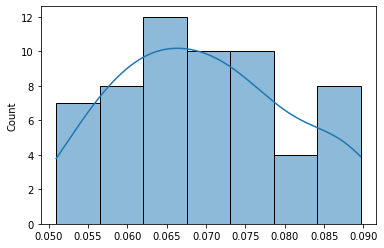

In [ ]:
sb.histplot(uniform_distribution, kde=True)

## **Stage 3.5 : Make different sorts of inputs**

In [ ]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

Text(0, 0.5, 'Current (nA)')

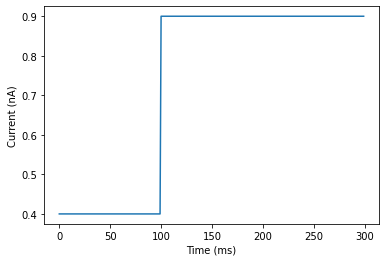

In [ ]:

# f = plt.figure()
plt1.plot(stairstep(0.4, 0.9, 100, 300))
plt1.xlabel('Time (ms)')
plt1.ylabel('Current (nA)')


**Stage 4: Coupling a neuron according to Freeman's KI Set with the weights given above**

In [ ]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        self.stim = h.IClamp(self.P1.dend(0.5))
        self.noise = np.random.normal(0, 0.001, 100)
        self.input = h.Vector(stairstep(0,0.1,10,100,self.noise))
        self.tv = h.Vector([i for i in range(100)])
        self.stim.delay = 10
        self.stim.dur = 100
        self.stim.amp = 0
        self.input.play(self.stim._ref_amp, self.tv, True) 
        
        
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        
        
        self.nc1.delay = 0.2 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = 0.3 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [ ]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
          print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [ ]:
#Give N value to get N no. of 2 coupled neurons laterally connected
given_input_from_user =size #  int(input('Enter the number of 2 coupled sets required: '))
L1=LATERAL(given_input_from_user,weights)
print(weights)

Lateral weight is 0.07418293893311315
Lateral weight is 0.06310870709128534
Lateral weight is 0.062213767346611895
Lateral weight is 0.05715842844078671
Lateral weight is 0.06286097333754673
Lateral weight is 0.07332565181067684
Lateral weight is 0.08703378315280402
Lateral weight is 0.055842689102178926
Lateral weight is 0.05880094239257975
Lateral weight is 0.06678916713191174
Lateral weight is 0.06436078752754376
Lateral weight is 0.07202342872458932
Lateral weight is 0.06476337553909596
Lateral weight is 0.08230886108847592
Lateral weight is 0.06907182871107737
Lateral weight is 0.07049336866611508
Lateral weight is 0.05845225926035411
Lateral weight is 0.06174809613620673
Lateral weight is 0.08928577739282274
Lateral weight is 0.062320961514538496
Lateral weight is 0.07049240157676073
Lateral weight is 0.07215741843219509
Lateral weight is 0.06331754737070021
Lateral weight is 0.07033577732622674
Lateral weight is 0.0550172057081598
Lateral weight is 0.0803034615763366
Lateral wei

**Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set**

In [ ]:
h.topology()


|-|       Set [1]_Mcell [1].soma(0-1)
   `|       Set [1]_Mcell [1].dend(0-1)
 `|       Set [1]_Mcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|-|       Set [2]_Mcell [1].soma(0-1)
   `|       Set [2]_Mcell [1].dend(0-1)
 `|       Set [2]_Mcell [1].axon(0-1)
|-|       Set [2]_Mcell [2].soma(0-1)
   `|       Set [2]_Mcell [2].dend(0-1)
 `|       Set [2]_Mcell [2].axon(0-1)
|-|       Set [3]_Mcell [1].soma(0-1)
   `|       Set [3]_Mcell [1].dend(0-1)
 `|       Set [3]_Mcell [1].axon(0-1)
|-|       Set [3]_Mcell [2].soma(0-1)
   `|       Set [3]_Mcell [2].dend(0-1)
 `|       Set [3]_Mcell [2].axon(0-1)
|-|       Set [4]_Mcell [1].soma(0-1)
   `|       Set [4]_Mcell [1].dend(0-1)
 `|       Set [4]_Mcell [1].axon(0-1)
|-|       Set [4]_Mcell [2].soma(0-1)
   `|       Set [4]_Mcell [2].dend(0-1)
 `|       Set [4]_Mcell [2].axon(0-1)
|-|       Set [5]_Mcell [1].soma(0-1)
   `|       Set [5]_Mcell [1].den

1.0

In [ ]:
# for sec in h.allsec():
#     print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

In [ ]:
# label=['spatial representation']
# h.PlotShape(True).plot(plt1)
# plt1.xlabel('length')
# plt1.ylabel('breadth')
# #plt1.zlabel('t (ms)')
# plt1.legend(label)

In [ ]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[0].stim
graph = h.Vector().record(recording_cell._ref_i)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300*ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(graph), line_width=2,legend_label='Input',line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

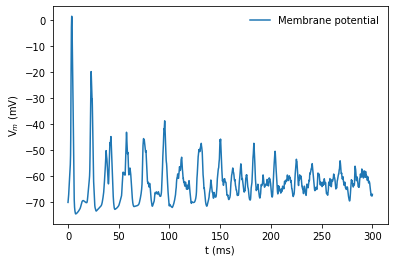

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

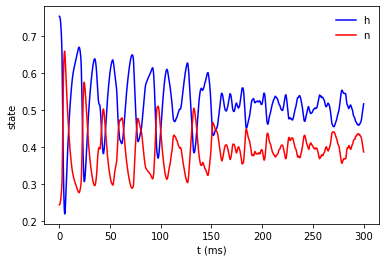

<IPython.core.display.Javascript object>

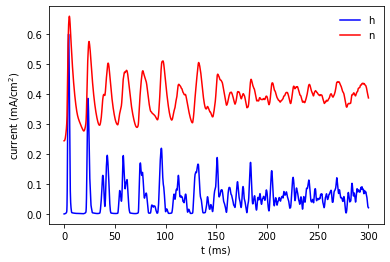

In [ ]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


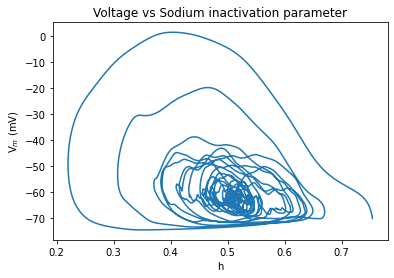

In [ ]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


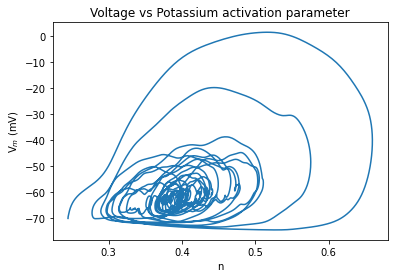

In [ ]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

**Stage 8: Record & visualize the voltage values at each axon and dendride**

In [ ]:
recording_cell = L1.sets[4].P1
print("The voltage at P1's axon:", recording_cell.axon(0.5).v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
print("The voltage at P1's dendrite:", recording_cell.dend(0.5).v)
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

The voltage at P1's axon: -72.06515730674464
The voltage at P1's dendrite: -76.94919804757129


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[4].P2
axon_P2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_P2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P2), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

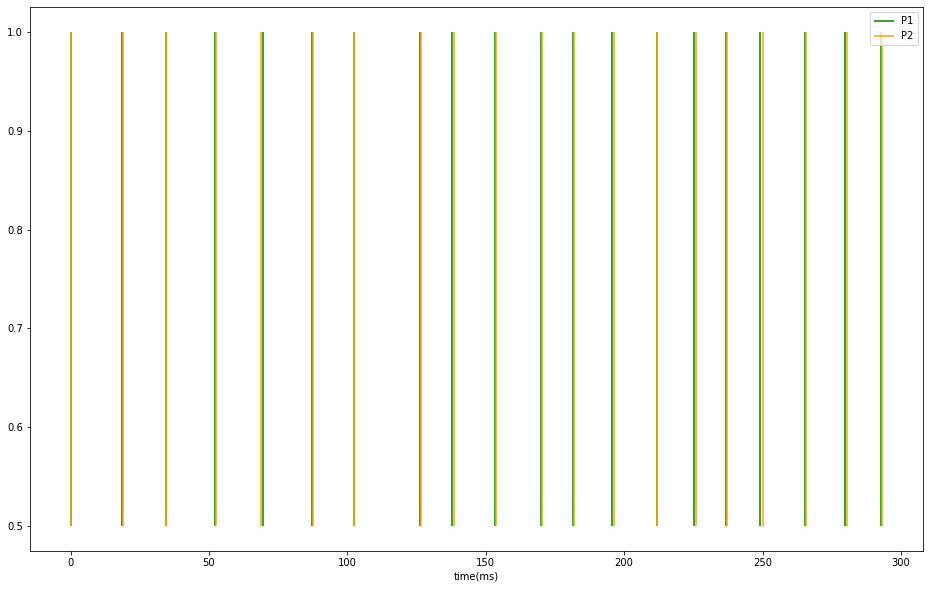

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(1):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.vlines(L1.sets[j].cells[0].spike_times+(100*j), 0.5, 1,color=color[0]) # for P1
    plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 0.5, 1, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)


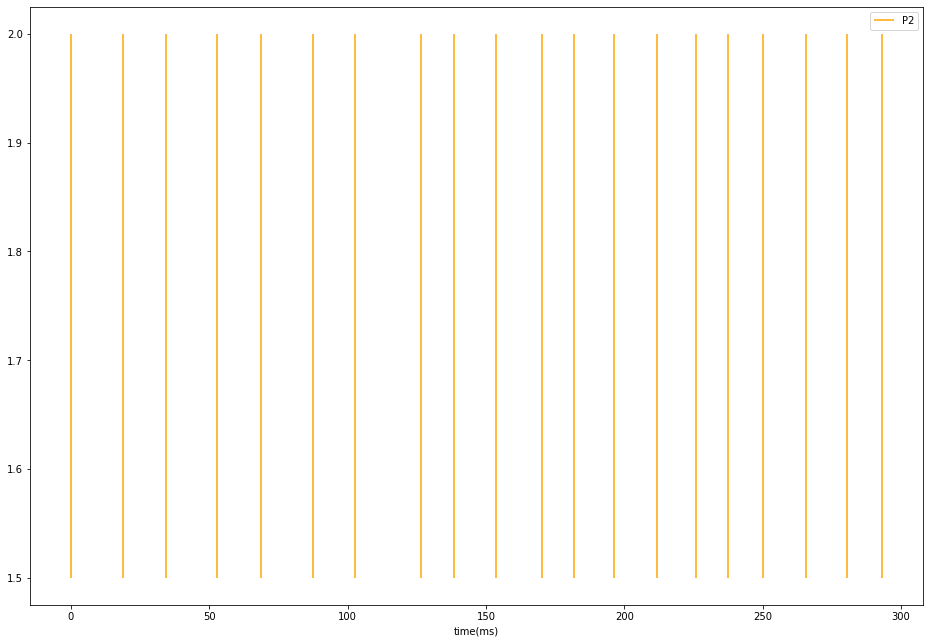

In [ ]:
color=['green','orange']
label=['P2']
plt1.figure(figsize=(16,11))
for j in range(1):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 1.5, 2,color=color[1]) # for P2
plt1.xlabel('time(ms)')
plt1.legend(label)

## Weights before learning

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

P1 before learning  P2 before learning
0                0.025               0.025
1               18.550              18.975
2               34.325              34.600
3               52.225              52.700
4               69.525              68.925
5               87.050              87.525
6              102.275             102.550
7              126.250             126.525
8              137.775             138.650
9              153.475             153.725
10             169.825             170.350
11             181.650             182.000
12             195.575             196.300
13             212.025             211.875
14             225.325             226.025
15             236.950             237.300
16             249.075             250.000
17             265.425             265.650
18             279.800             280.425
19             292.925             293.250

### **Before learning Firing rate**

In [ ]:
fr_P1=[0 for i in range(len(L1.sets))]
fr_P2=[0 for i in range(len(L1.sets))]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  #print("spikes of p1", t)
  t1=list(L1.sets[f].cells[1].spike_times)
  #print("spikes of p2", t1)
  fr_P1[f]=(len(t)/100)*1000
  fr_P2[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1)
#print("frequencies of P2 in each set", fr_P2)

c=[0 for i in range(size*2)]
for i in range(size):
  c[i*2]=fr_P1[i]
  c[i*2+1]=fr_P2[i]
print("Frequencies of each neuron before learning", c)

Frequencies of each neuron before learning [200.0, 200.0, 210.0, 210.0, 200.0, 200.0, 220.0, 210.0, 190.0, 190.0, 230.0, 210.0, 220.0, 210.0, 210.0, 210.0, 220.0, 220.0, 210.0, 210.0, 190.0, 190.0, 220.0, 200.0, 220.0, 220.0, 250.0, 240.0, 250.0, 230.0, 240.0, 240.0, 240.0, 240.0, 210.0, 210.0, 190.0, 190.0, 210.0, 210.0, 220.0, 210.0, 210.0, 210.0, 190.0, 190.0, 200.0, 190.0, 200.0, 190.0, 220.0, 200.0, 200.0, 200.0, 200.0, 200.0, 210.0, 210.0, 210.0, 200.0]


## Population Activity (Before Learning)

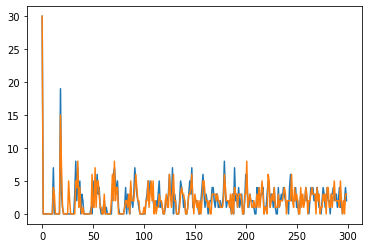

In [ ]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [ ]:
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

### **Stage 9:Learning**

In [ ]:
# epochs = 50
# import numpy as np
# import math
# out_1_1_data = []
# A_plus = 0.01      #0.2 to 2.5
# A_minus = -0.01
# tau_pre = 20*ms
# tau_post = 20*ms

# weights_rec = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# weights_rec_2 = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# L_weights_rec= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]
# L_weights_rec_2= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]

# for l in range(epochs):  
#     print("\niteration no is",l)
#     P1_data = []
#     print("\nmutual learning")
#     for i in range(len(L1.sets)):
#         h.continuerun(300 *ms)
#         out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#         # print("Spike times P{0}".format(1+i*2), list(L1.sets[i].P1.spike_times))
#         spike_1_1 = list(L1.sets[i].P1.spike_times)
#         out_1_2 = h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)
#         spike_1_2 = list(L1.sets[i].P2.spike_times)
#         # print("Spike times P{0}".format(2+i*2), list(L1.sets[i].P2.spike_times))
#         t = h.Vector().record(h._ref_t)
#         h.finitialize(-70 * mV)
        
#         for k in range(1,3):
#             delta_t = [(spike_1_2[iter] - spike_1_1[iter]) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0.24 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w = sum(delta_w_list)
#             exec(f"L1.sets[i].nc{k}.weight[0] += delta_w")         
#         P1_data.append(list(out_1_1))
#         print("weight:", L1.sets[i].nc1.weight[0])
#         weights_rec[i][l] = L1.sets[i].nc1.weight[0]
#         weights_rec_2[i][l] = L1.sets[i].nc2.weight[0]    



# #Lateral Learning
#     print("\tlateral learning")
#     for i in range(len(L1.sets)-1):
#       h.continuerun(300 *ms)
#       out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(1+2*i), list(L1.sets[i].P1.spike_times))
#       spike_1_1 = list(L1.sets[i].P1.spike_times)
#       out_2_1 = h.Vector().record(L1.sets[i+1].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(3+2*i), list(L1.sets[i+1].P1.spike_times))
#       spike_2_1 = list(L1.sets[i+1].P1.spike_times)
#       h.finitialize(-70 * mV)

#       # change the deltas
      
#       L1.netConArr[i][0].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)
#       L1.netConArr[i][1].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)

#       # Logging work

#       print(L1.netConArr[i][0].weight[0])
#       L_weights_rec[i][l] = L1.netConArr[i][0].weight[0]
#       L_weights_rec[i][l] = L1.netConArr[i][1].weight[0]
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i], spike_M1_data[i+1])")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i+1], spike_M1_data[i])")
#       # print("lateral weight is : ",L1.nc11_0.weight[0])  
#       # L_weights_rec[i][l] = L1.nc11_0.weight[0]
#       # L_weights_rec_2[i][l]=L1.nc12_i.weight[0] 
#       # exec(f"print(L1.nc11_{i}.weight[0])")
#       # exec(f"L_weights_rec[i][l]=L1.nc11_{i}.weight[0]")
#       # exec(f"L_weights_rec_2[i][l]=L1.nc12_{i}.weight[0]")

In [ ]:
import sys, time
tick = time.time()
epochs = 100
weight_data = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    M1_axon_data = []
    M1_dend_data = []
    M2_axon_data = []
    M2_dend_data = []
    G1_axon_data = []
    G1_dend_data = []
    G2_axon_data = []
    G2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []
    M1_spike_times = []
    M2_spike_times = []
    G1_spike_times = []
    G2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
        P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
        P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
        P1_spike_times.append(list(L1.sets[i].P1.spike_times))
        P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
        P2_spike_times.append(list(L1.sets[i].P2.spike_times))
        P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # 2-coupled STDP-based learning
        L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # logging
        # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        
    # do a proper logging function
    weight_data.append(L1.sets[0].nc1.weight[0])


    #Lateral Learning
    for i in range(len(L1.sets)-1):
        # 2-coupled part
        L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
        L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
    

out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The time it took to learn 53.679219007492065 seconds


In [ ]:
# print(sum([len(list(cell.cells[0].spike_times)) for cell in L1.sets])/(len(L1.sets)*300))
# print(sum([len(list(cell.cells[1].spike_times)) for cell in L1.sets])/(len(L1.sets)*300))


In [ ]:
## TODO: Check what kind of distribution is followed by the output

## Weights after learning

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 after learning': P1_spike_times, 'P2 after learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 after learning  P2 after learning
0               0.025              0.025
1              24.150             24.125
2              40.875             41.125
3              63.150             63.375
4              80.200             80.450
5             102.400            102.625
6             123.825            124.050
7             145.250            145.475
8             166.875            167.100
9             184.075            184.325
10            189.950            190.350
11            201.900            202.175
12            210.175            210.475
13            221.675            222.000
14            227.625            228.000
15            245.075            245.325
16            251.650            251.975
17            264.850            265.125
18            271.050            271.400
19            288.100            288.350
20            294.925            295.250

**Stage 8: Record & visualize the voltage values at each axon and dendride after learning**

In [ ]:
recording_cell = L1.sets[2].P1
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
print(recording_cell.axon(0.5).v)
h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

-66.35978869373544


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recording_cell = L1.sets[2].P2
axon_P1 = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(100 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# print(weight_data)
f = plt2.figure(x_axis_label='epochs')
x = [i for i in range(epochs)]
f.line(x, weight_data, line_width=1, line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

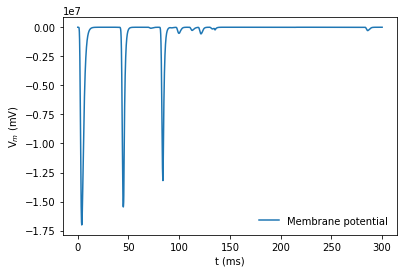

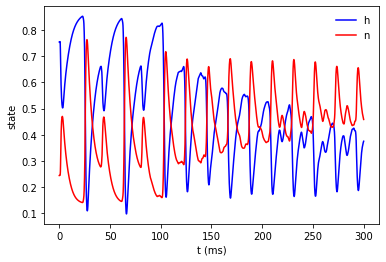

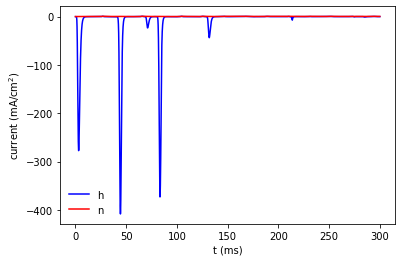

In [ ]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


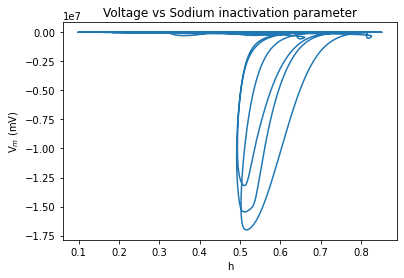

In [ ]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


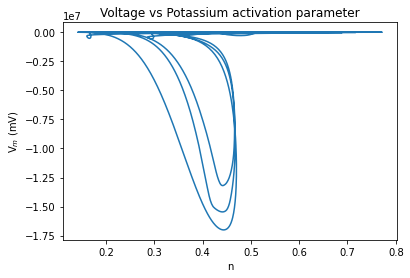

In [ ]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

## Population Activity

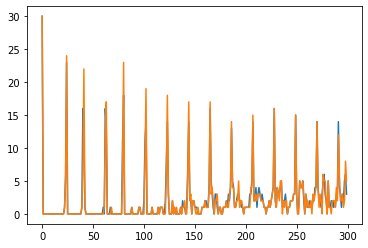

In [ ]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [ ]:
# count, bins, ignored = plt1.hist(weights_rec[0], 10)
# # Plot the distribution curve
# # plt1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.show()
# print(weights_rec[0])

In [ ]:
# f = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(L_weights_rec[0]))]
# f.line(x, L_weights_rec[3], line_width=1, legend_label='nc11', line_color='blue')
# f.line(x, L_weights_rec_2[0], line_width=2, legend_label='nc12', line_color='red', line_dash='dotted')
# plt2.show(f)

### **Raster scan for short intervals**

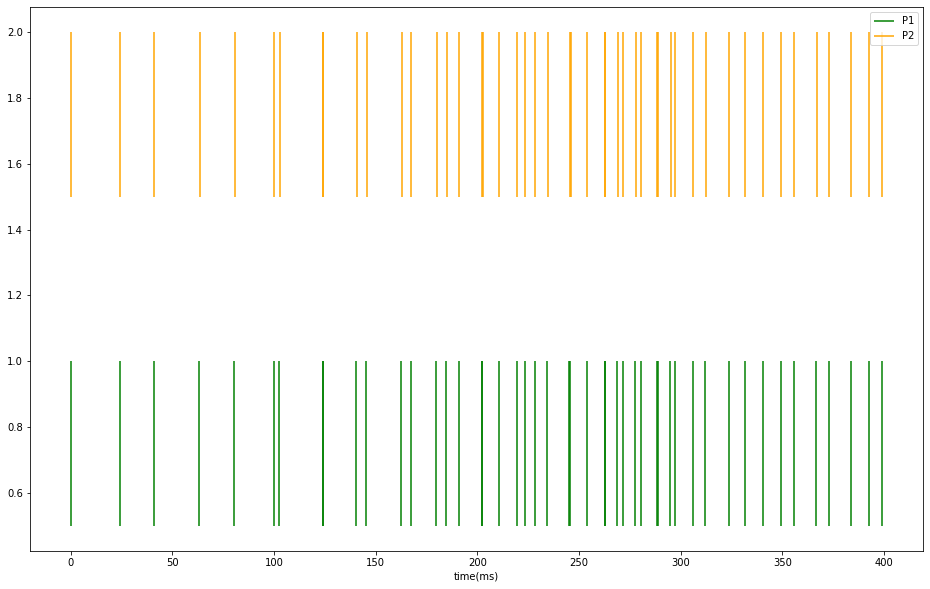

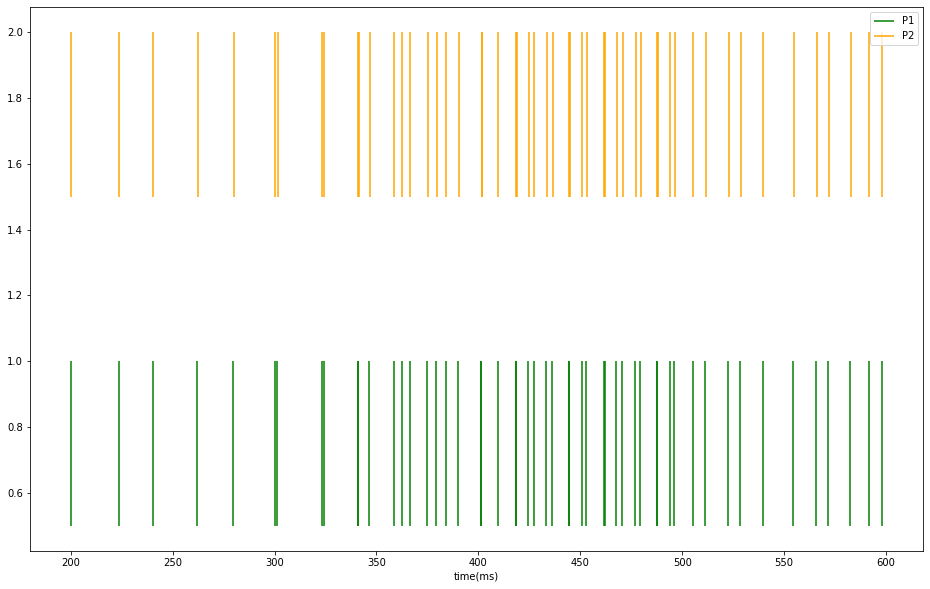

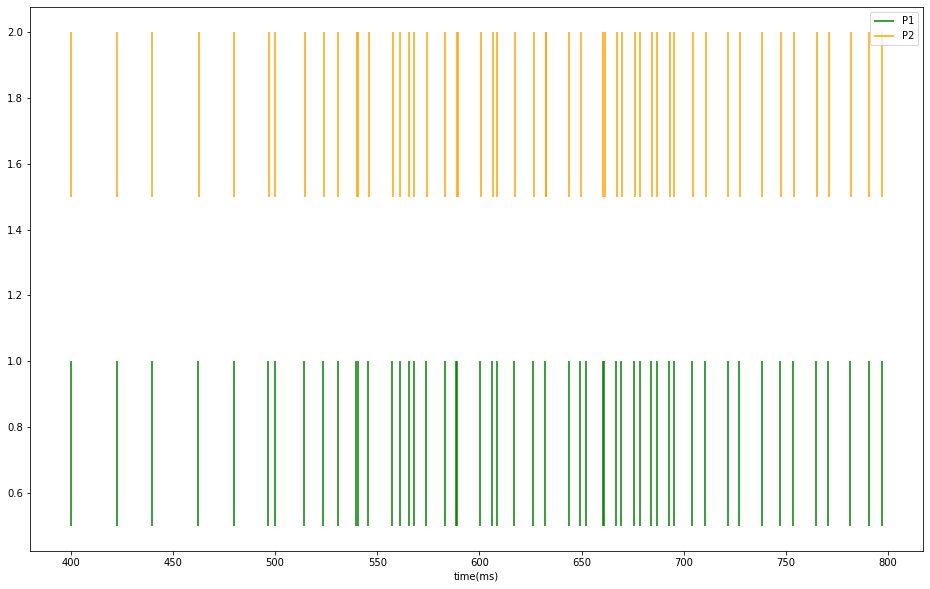

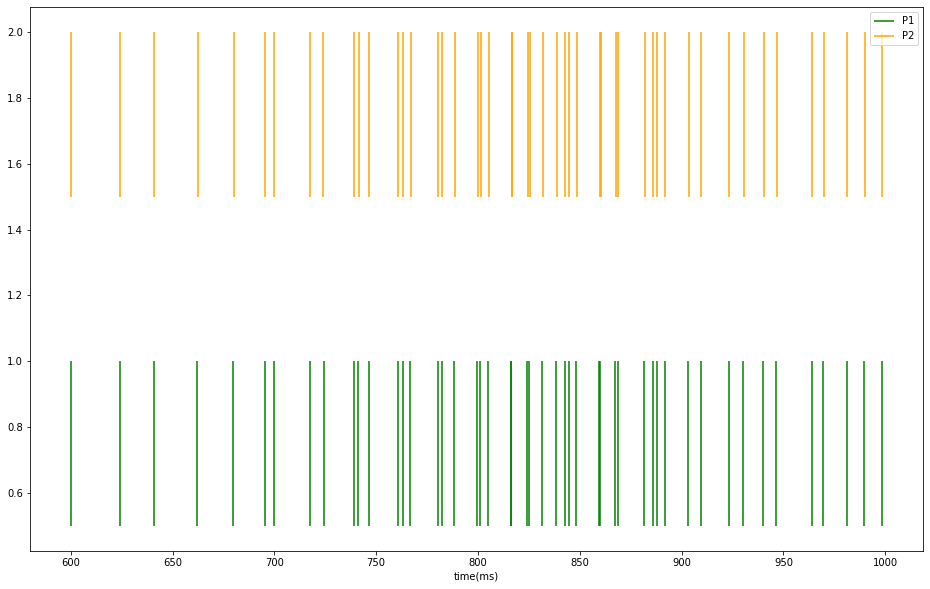

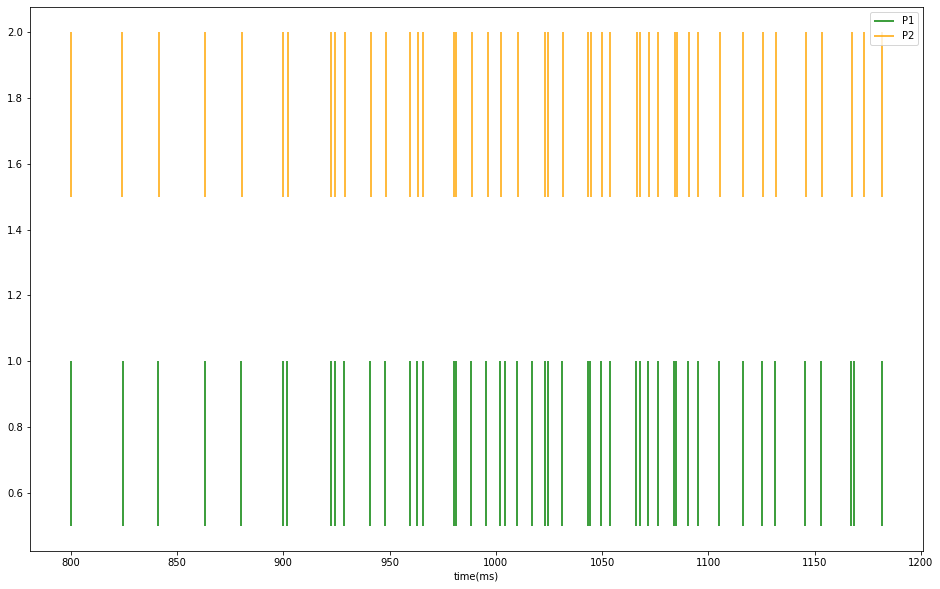

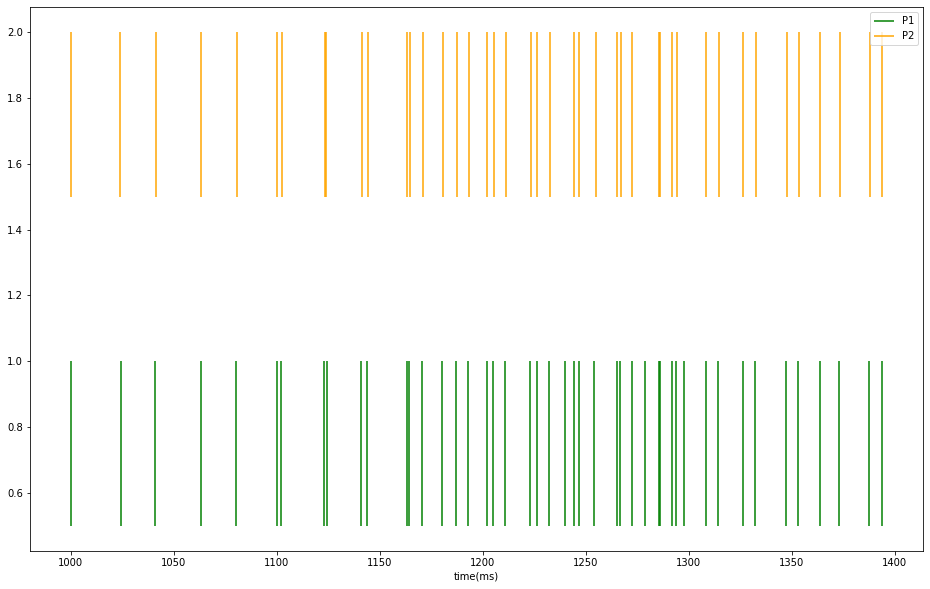

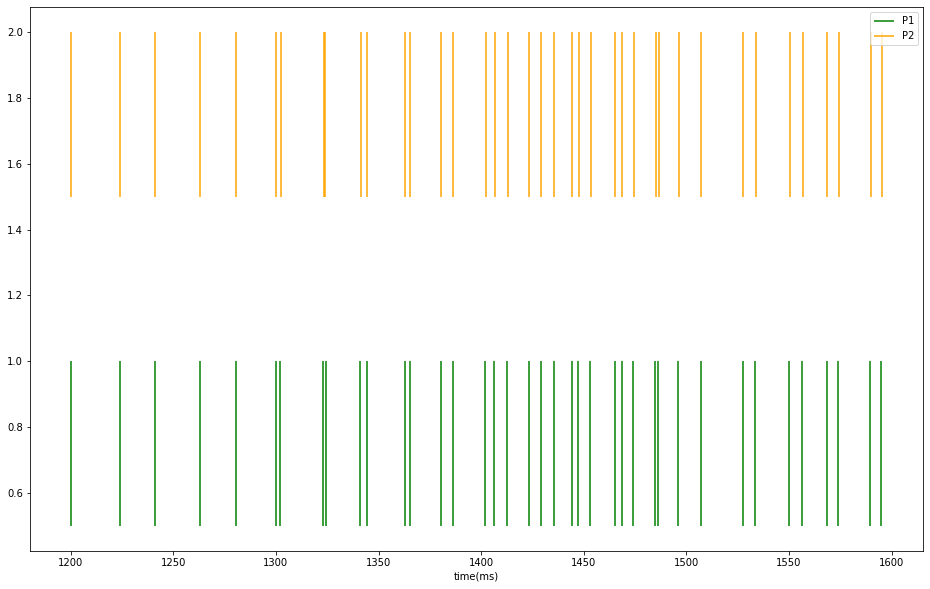

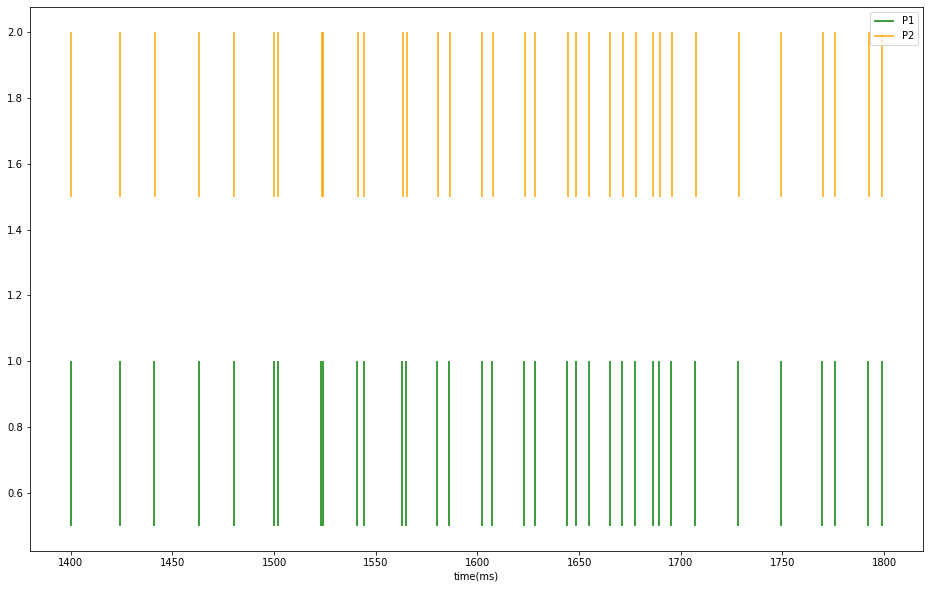

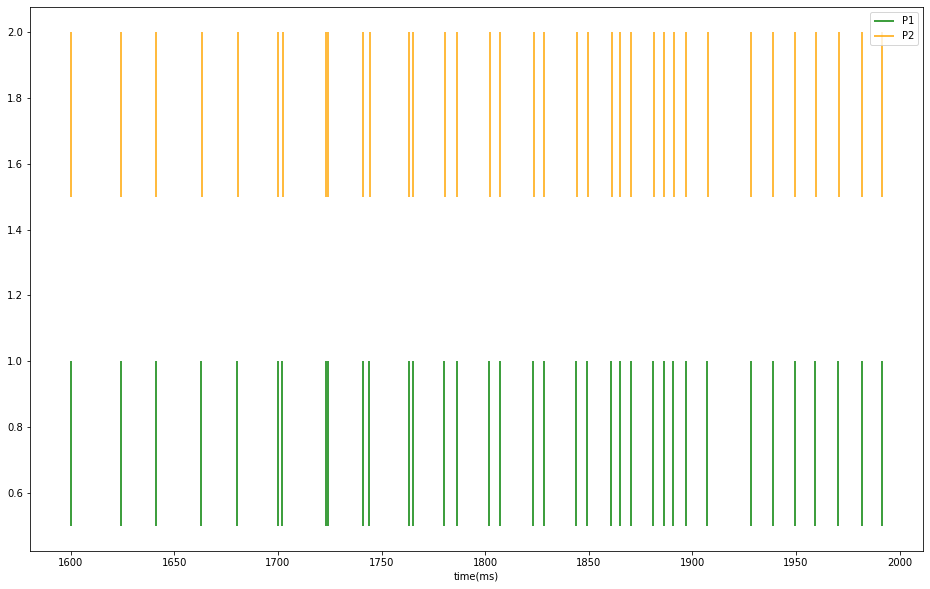

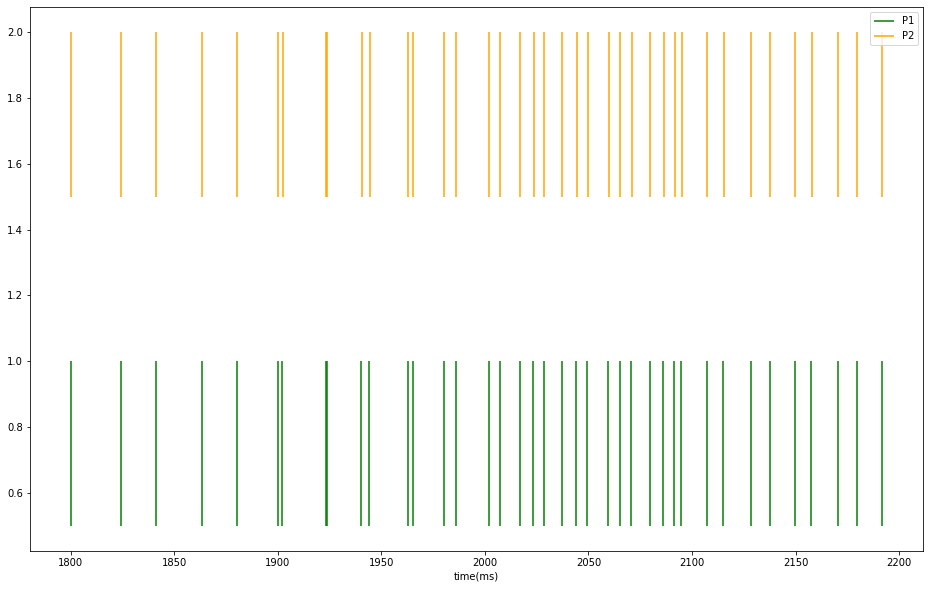

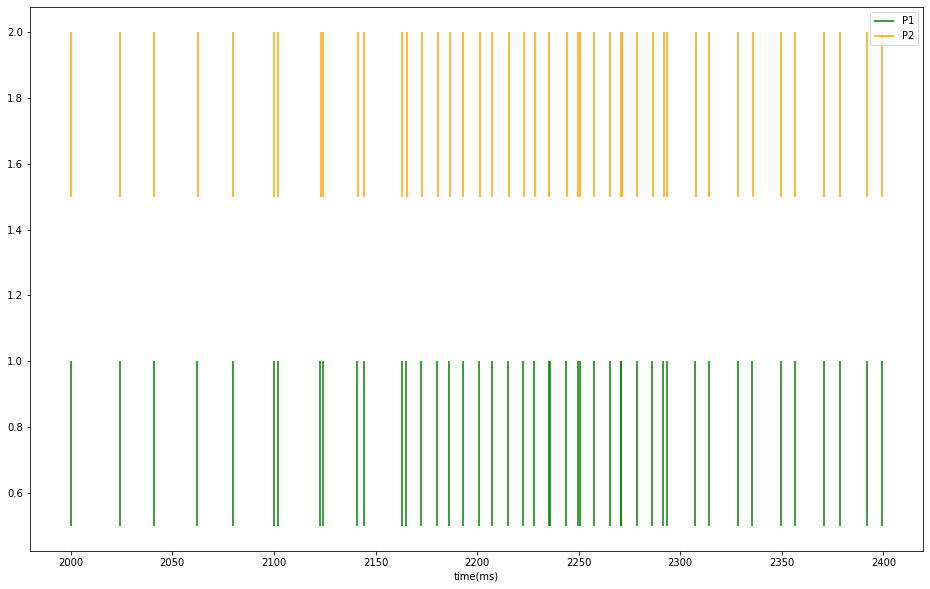

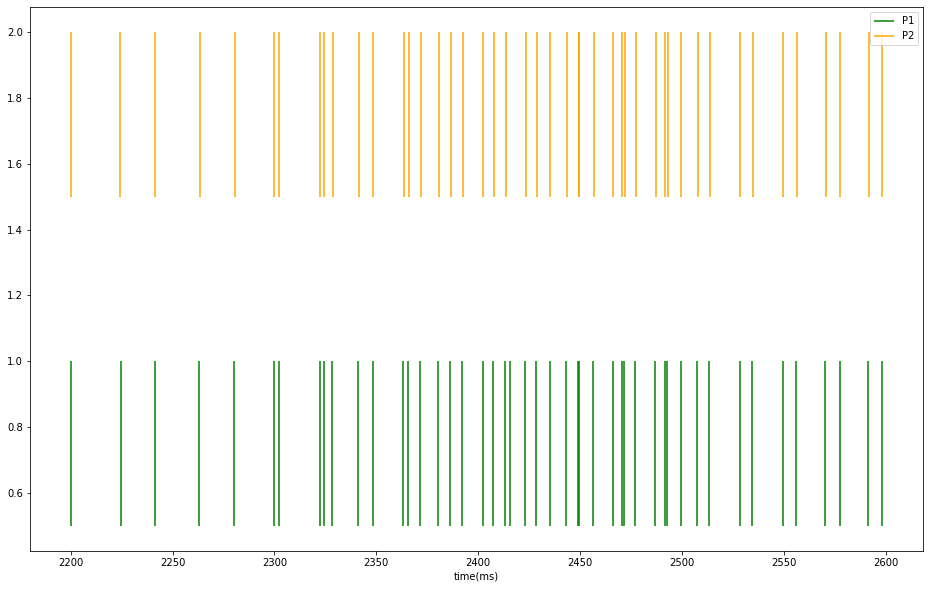

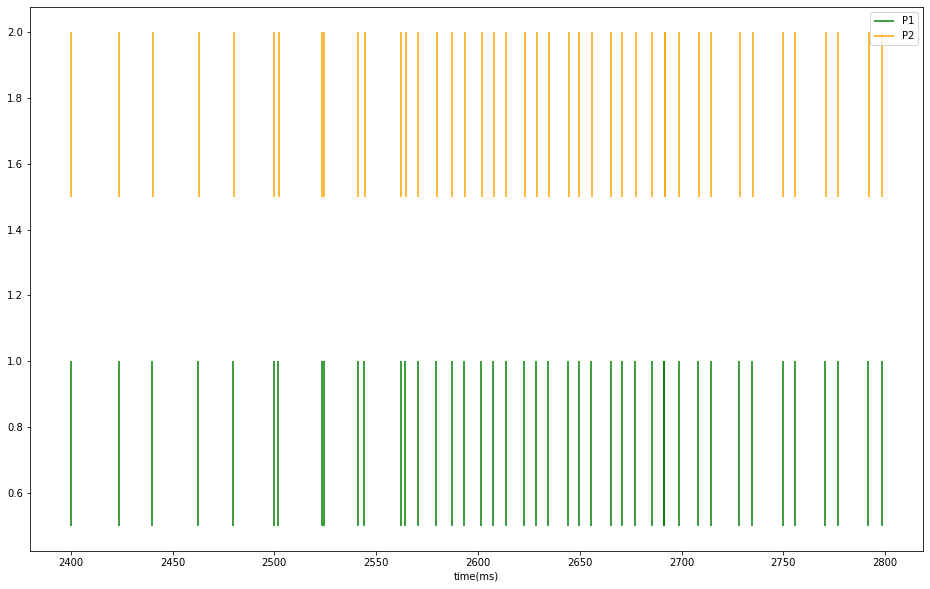

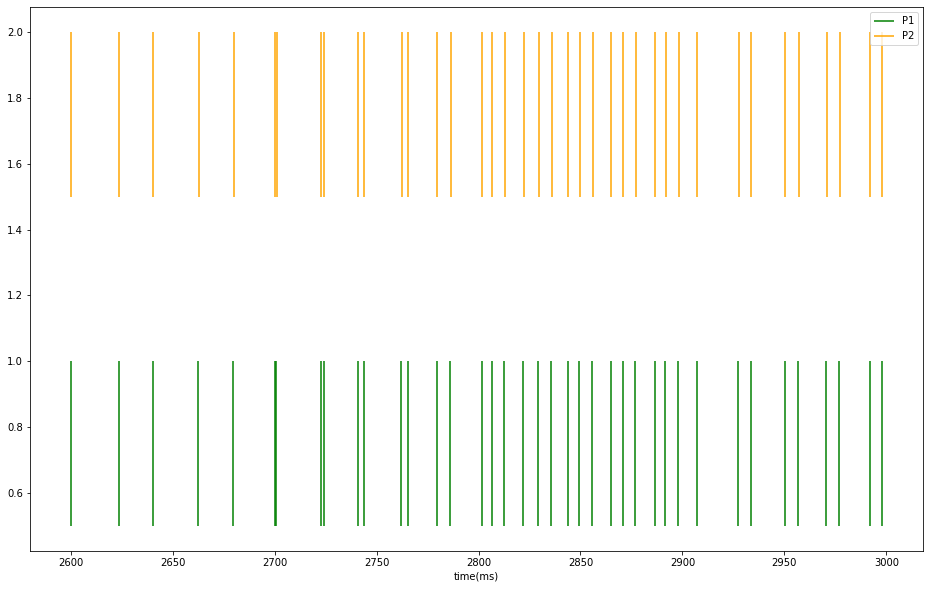

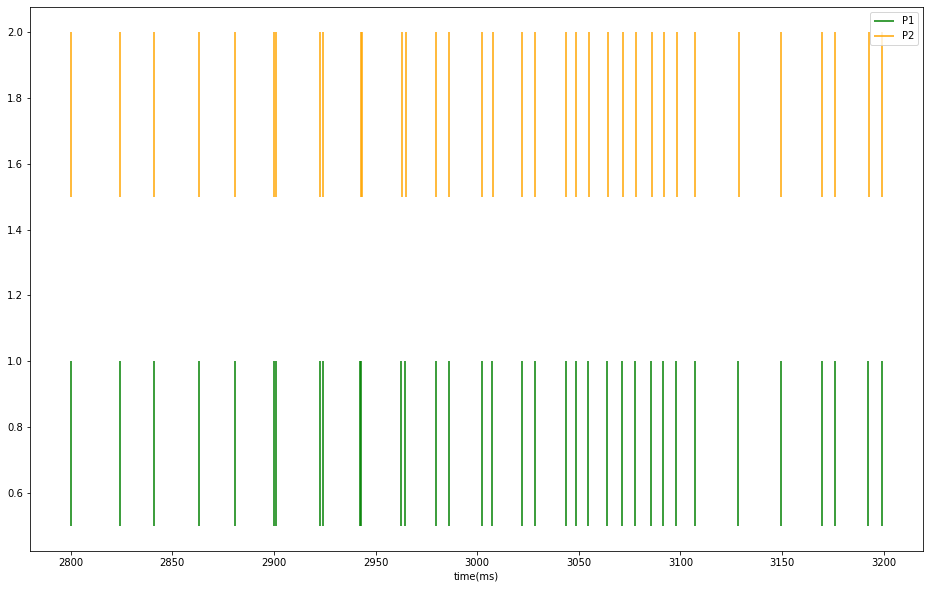

In [ ]:
interval=2 #no.of pairs for each raster scan(if interval is 1 each pair would be displayed individually)
start=0
end=interval
lis=int(size/end)
for k in range(lis):
  color=['green','orange']
  label=['P1','P2']
  plt1.figure(figsize=(16,10))
  for j in range(start,end):
      for i,cell in enumerate(L1.sets[j].cells):
          plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
  plt1.xlabel('time(ms)')
  plt1.legend(label)
  start=end
  end=end+interval


[0.025000000100000003, 24.17500000009916, 40.875000000100734, 63.30000000010583, 80.3500000001097, 102.52500000011474, 124.10000000011965, 145.45000000010464, 167.1500000000849, 184.82500000006883, 190.8000000000634, 202.50000000005275, 210.45000000004552, 219.30000000003747, 228.15000000002942, 234.30000000002383, 245.6500000000135, 253.72500000000616, 262.5749999999981, 271.44999999999004, 277.7499999999843, 288.79999999997426, 294.94999999996867]
[0.025000000100000003, 24.17500000009916, 40.875000000100734, 63.30000000010583, 80.3500000001097, 102.52500000011474, 124.10000000011965, 145.45000000010464, 167.1500000000849, 184.82500000006883, 190.8000000000634, 202.50000000005275, 210.45000000004552, 219.30000000003747, 228.15000000002942, 234.30000000002383, 245.6500000000135, 253.72500000000616, 262.5749999999981, 271.44999999999004, 277.7499999999843, 288.79999999997426, 294.94999999996867]


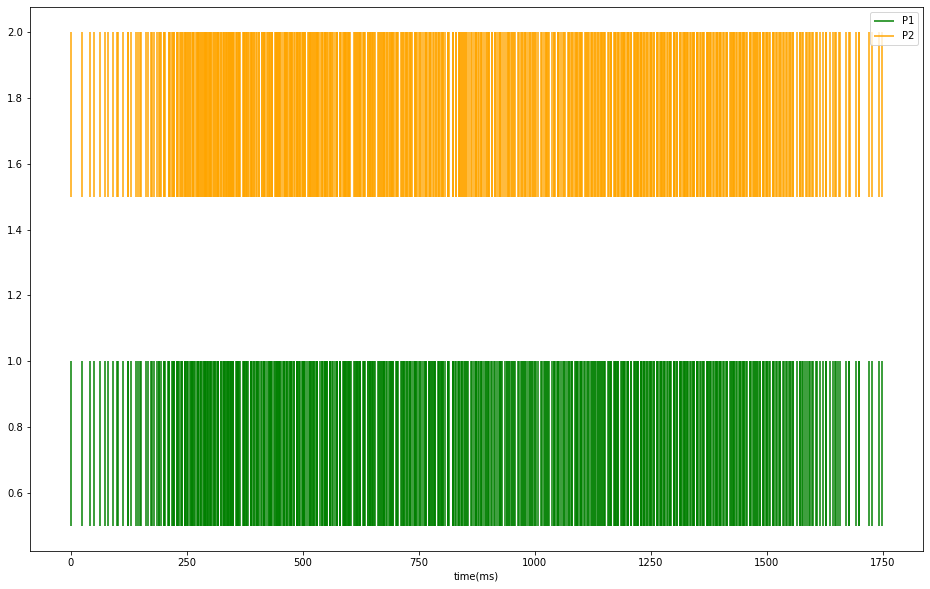

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(50*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[0].cells[0].spike_times)
print(t1)
print(t2)

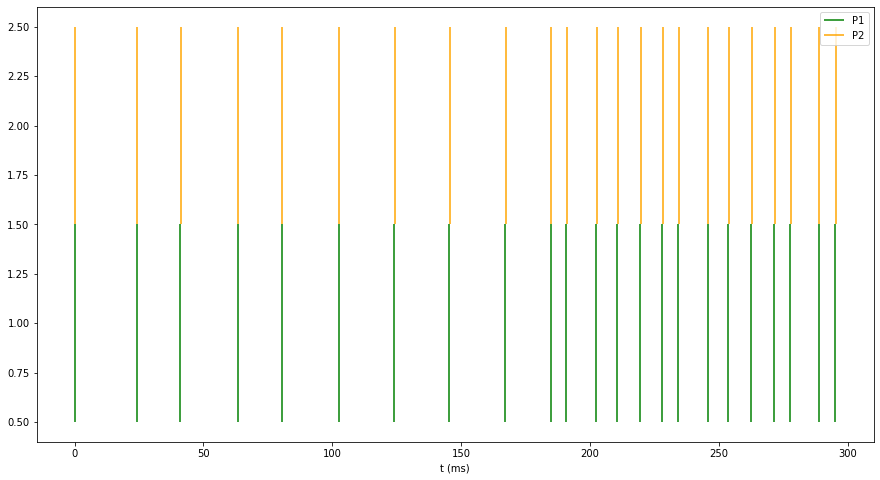

In [ ]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[0].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

In [ ]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               24.175              24.150
2               40.875              41.125
3               63.300              63.525
4               80.350              80.600
5              102.525             102.750
6              124.100             124.325
7              145.450             145.675
8              167.150             167.375
9              184.825             185.075
10             190.800             191.175
11             202.500             202.775
12             210.450             210.750
13             219.300             219.625
14             228.150             228.475
15             234.300             234.700
16             245.650             245.925
17             253.725             254.025
18             262.575             262.900
19             271.450             271.775
20             277.750             278.125
21             288.800             289.075
22             294.950             295.300